#Loading Dataset

In [1]:
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

--2019-01-03 03:15:51--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.50.44
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.50.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  34.0MB/s    in 9.1s    

2019-01-03 03:16:01 (32.5 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]



#Unzipping Zipped Dataset

In [0]:
!unzip flower_data.zip

#Installing Pytorch 0.4.0 Compatible with Lab Challenge Project Version

In [3]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x57884000 @  0x7fa5f06012a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.1
True


In [4]:
# install pillow 
!pip uninstall -y Pillow
!pip install Pillow==4.1.1


Uninstalling Pillow-5.4.0:
  Successfully uninstalled Pillow-5.4.0
    100% |████████████████████████████████| 5.7MB 6.3MB/s 


#Developing an AI application
Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, we'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice we'd train this classifier, then export it for use in our application. We'll be using this dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

 img src='assets/Flowers.png' width=500px

The project is broken down into multiple steps:

Loading and preprocessing the image dataset
Training the image classifier on our dataset
Using the trained classifier to predict image content
We'll implement everything in Python.

When we've completed this project, we'll have an application that can be trained on any set of labeled images. Here our network will be learning about flowers and end up as a command line application. But, what we do with your new skills depends on our imagination and effort in building a dataset. For example, imagine an app where we take a picture of a car, it tells us what the make and model is, then looks up information about it. 

First up is importing the packages we'll need.

In [0]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import os, random
import json

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import copy
import time

import json


In [52]:
import PIL
print(PIL.PILLOW_VERSION)
print(PIL.PILLOW_VERSION)


4.0.0
4.0.0


#Loading the data
Here we'll use torchvision to load the data (documentation). The dataset is split into 2 parts, training and validation. For the training, we'll apply transformations such as random scaling, cropping, and flipping (Data Augmentation). This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and Testing set are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

The Test dataset is present inside Udacity Challenge Lab! 

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'


In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


#Loading Json Data

In [9]:
!wget https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json

--2019-01-03 03:17:52--  https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2019-01-03 03:17:52 (47.8 MB/s) - ‘cat_to_name.json’ saved [2218/2218]



In [0]:
dirs = {'train': train_dir,
        'valid': valid_dir}

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(35),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in
               ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x])
                 for x in ['train', 'valid']}
class_names = image_datasets['train'].classes


#Label mapping
We'll also need to load in a mapping from category label to category name. I have already Downloaded it. It's a JSON object which we can read in with the json module. This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

#Building and training the classifier
Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from torchvision.models to get the image features. Building and training a new feed-forward classifier using those features.

Loading a pre-trained network. Defining a new, untrained feed-forward network as a classifier, using ReLU activations and dropout. Training the classifier layers using backpropagation using the pre-trained network to get the features. Tracking the loss and accuracy on the validation set to determine the best hyperparameters.


In [12]:
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False



/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:02<00:00, 14118573.48it/s]


In [0]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout.
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 102)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features.
# Track the loss and accuracy on the validation set to determine the best hyperparameters.
def train_model(model, criteria, optimizer, scheduler, num_epochs):
    """
    Train the model
    :param model:
    :param criteria:
    :param optimizer:
    :param scheduler:
    :param num_epochs:
    :param device:
    :return:
    """
    model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
  

#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, 102)

model = model.to(device)
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = optim.lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
# Number of epochs
eps = 60

#device = "cuda" if torch.cuda.is_available() else "cpu"
model_ft = train_model(model, criteria, optimizer_ft, sched, eps)


Epoch 0/59
----------
train Loss: 3.3689 Acc: 0.3315
valid Loss: 2.2221 Acc: 0.5562

Epoch 1/59
----------
train Loss: 1.8364 Acc: 0.6807
valid Loss: 1.3067 Acc: 0.7738

Epoch 2/59
----------
train Loss: 1.2818 Acc: 0.7691
valid Loss: 0.9685 Acc: 0.8105

Epoch 3/59
----------
train Loss: 1.0214 Acc: 0.8083
valid Loss: 0.7934 Acc: 0.8447

Epoch 4/59
----------
train Loss: 0.8914 Acc: 0.8230
valid Loss: 0.6728 Acc: 0.8692

Epoch 5/59
----------
train Loss: 0.7536 Acc: 0.8527
valid Loss: 0.5998 Acc: 0.8802

Epoch 6/59
----------
train Loss: 0.6974 Acc: 0.8567
valid Loss: 0.4988 Acc: 0.9010

Epoch 7/59
----------
train Loss: 0.6376 Acc: 0.8701
valid Loss: 0.4722 Acc: 0.9071

Epoch 8/59
----------
train Loss: 0.6036 Acc: 0.8729
valid Loss: 0.4449 Acc: 0.8998

Epoch 9/59
----------
train Loss: 0.5695 Acc: 0.8755
valid Loss: 0.4067 Acc: 0.9132

Epoch 10/59
----------
train Loss: 0.5437 Acc: 0.8805
valid Loss: 0.3802 Acc: 0.9193

Epoch 11/59
----------
train Loss: 0.5338 Acc: 0.8771
valid Loss

#Testing My network
It's good practice to test our trained network on test data but here as we we don't have the Test data, so we will use Valid data set only.This will give us a fair estimate for the model's performance on completely new images. Running the Valid images through the network and measure the accuracy, the same way we did validation. We have reached 94.376% overall accuracy

#Saving the checkpoint
Now that our network is trained, saving the model so we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets: image_datasets['train'].class_to_idx. We can attach this to the model as an attribute which makes inference easier later on.

model.class_to_idx = image_datasets['train'].class_to_idx

Remember that we'll want to completely rebuild the model later so we can use it for inference. Making sure to include any information we need in the checkpoint. If we want to load the model and keep training, we'll want to save the number of epochs as well as the optimizer state, optimizer.state_dict. We'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
model_ft.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'input_size': 1024,
              'output_size': 102,
              'arch': 'densenet121',
              'learning_rate': 0.001,
              'batch_size': 64,
              'classifier' : model.classifier,
              'epochs': 60,
              'optimizer': optimizer_ft.state_dict(),
              'state_dict': model_ft.state_dict(),
              'class_to_idx': model_ft.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')





#Loading the checkpoint
At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [56]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    learning_rate = checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model
model = load_checkpoint('checkpoint.pth')


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


#Inference for classification
Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. Writing a function called predict that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
First we'll need to handle processing the input image such that it can be used in our network.

#Image Preprocessing
We'll want to use PIL to load the image (documentation). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resizing the image where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the thumbnail or resize methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. We'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model   
    new_size = [0, 0]

    if image.size[0] > image.size[1]:
        new_size = [image.size[0], 256]
    else:
        new_size = [256, image.size[1]]
    
    image.thumbnail(new_size, Image.ANTIALIAS)
    width, height = image.size  

    left = (256 - 224)/2
    top = (256 - 224)/2
    right = (256 + 224)/2
    bottom = (256 + 224)/2

    image = image.crop((left, top, right, bottom))
    
    image = np.array(image)
    image = image/255.
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std
    
    image = np.transpose(image, (2, 0, 1))
    
    return image

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our process_image function works, running the output through this function should return the original image (except for the cropped out portions).



In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

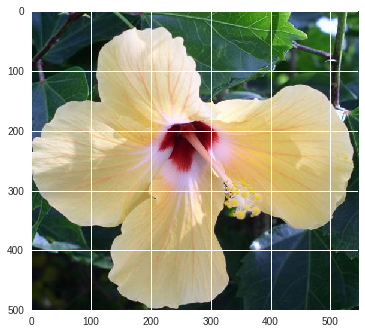

In [83]:
# Show original picture
img_path = valid_dir + '/83/image_01697.jpg'

with Image.open(img_path) as image:
    plt.imshow(image)

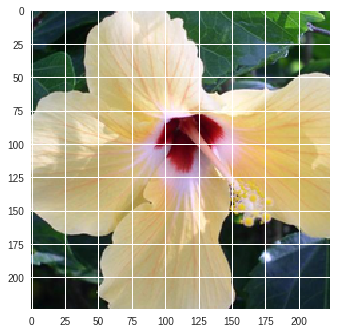

In [84]:
# Show processed picture
with Image.open(img_path) as image:
    imshow(process_image(image))

#Class Prediction
Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 10 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using class_to_idx which hopefully we added to the model or from an ImageFolder you used to load the data (see here). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [0]:
def predict(image_path, model, topk=10):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    cuda = torch.cuda.is_available() 
    
    if cuda:
        model = model.cuda()
    else:
        model = model.cpu()
        
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)
    
    if cuda:
        inputs = Variable(tensor.float().cuda())
    else:       
        inputs = Variable(tensor)
        
    inputs = inputs.unsqueeze(0)
    output = model.forward(inputs)
    
    ps = torch.exp(output).data.topk(topk)
    probabilities = ps[0].cpu()
    classes = ps[1].cpu()
    class_to_idx_inverted = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    
    for label in classes.numpy()[0]:
        mapped_classes.append(class_to_idx_inverted[label])
        
    return probabilities.numpy()[0], mapped_classes

[8.6679657e+01 1.1222967e-01 8.2520284e-02 3.8536184e-02 2.8369324e-02
 1.8489158e-02 1.7419612e-02 1.4120440e-02 1.0374165e-02 8.1939753e-03]
['83', '76', '86', '89', '43', '78', '91', '75', '51', '18']
['hibiscus', 'morning glory', 'tree mallow', 'watercress', 'sword lily', 'lotus lotus', 'hippeastrum', 'thorn apple', 'petunia', 'peruvian lily']


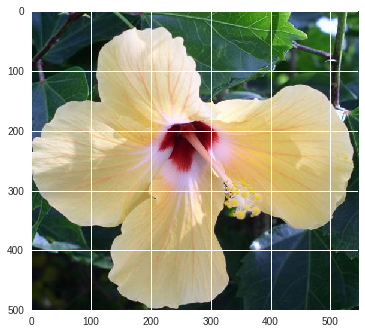

In [88]:
with  Image.open(img_path) as image:
    plt.imshow(image)
    
prob, classes = predict(img_path, model)
print(prob)
print(classes)
print([cat_to_name[x] for x in classes])

#Sanity Checking
Now that we can use a trained model for predictions, checking to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Using matplotlib to plot the probabilities for the top 10 classes as a bar graph, along with the input image. 

We can convert from the class integer encoding to actual flower names with the cat_to_name.json file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the imshow function defined above.

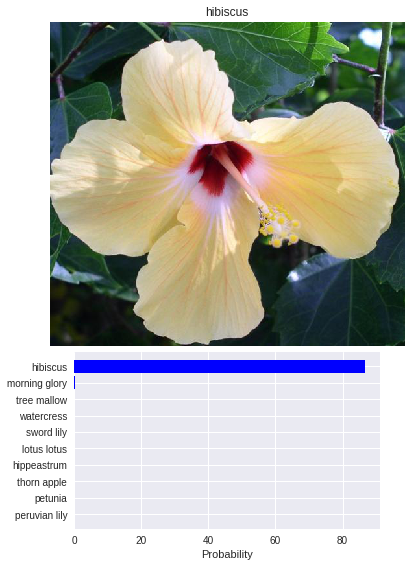

In [89]:
# TODO: Display an image along with the top 10 classes
prob, classes = predict(img_path, model)
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(img_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)

labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
    
y_pos = np.arange(10)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

plt.show()